## Problem 2

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import random
import math
import time
import func3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [2]:
def seqGen(n, ratio):
    ind = random.sample(range(10), 5)
    ind.sort()
    randmu = 2*torch.rand((5)) - 1
    T = random.randint(0, n)
    haspoint = random.random()
    seq = torch.randn((n,10))
    haschange = False
    if haspoint <= ratio:
        haschange = True
        for t in range(n):
                j = 0
                for i in range(10):
                    if i in ind:
                        seq[t][i] = seq[t][i] + randmu[j]
                        j = j+1
        
        
        
    return seq, ind, randmu, haschange, T

In [26]:
seq, ind, randmu, haspoint, T = seqGen(50, 0.8)
print(len(seq))
print(ind)
print(randmu)
print(haspoint, T)
for i in range(len(seq)):
    print(i, seq[i])

50
[1, 2, 6, 7, 8]
tensor([-0.9562, -0.3473, -0.9875,  0.1532, -0.2156])
0.6161402811144422 32
0 tensor([-0.8207,  0.1794,  0.3079,  1.6066, -0.4839, -0.7526, -2.0831,  1.8277,
        -0.1502,  0.3111])
1 tensor([-0.2142, -1.0767,  0.4379, -0.2036, -0.5312,  0.1712, -1.0970, -0.1783,
         0.9725,  1.3602])
2 tensor([ 0.5295, -1.6347, -1.7138, -0.1080, -1.4227, -0.2295, -3.5396, -0.7612,
        -0.0229, -1.0080])
3 tensor([ 0.1370, -2.4191,  0.1669, -0.5856,  1.0850,  0.2412, -2.5732,  0.5730,
        -1.6587,  2.1049])
4 tensor([ 0.1950, -1.4301,  0.8942, -0.4636,  0.4511, -1.3616, -2.6730, -0.4233,
         0.4155, -1.8123])
5 tensor([ 0.5021, -1.9498,  1.4541, -0.6365,  0.8206,  1.6822, -0.5846, -1.8780,
         0.7893,  1.2262])
6 tensor([ 2.2820, -1.8379,  0.4255, -1.2552, -1.9233,  0.0566, -0.8474, -0.0619,
        -1.3124, -1.2023])
7 tensor([ 0.7467, -1.6236,  1.7891,  0.6751, -1.5157, -0.5240, -1.5478,  0.0749,
        -2.2192, -0.0554])
8 tensor([-0.3317, -1.1479, -0.64

In [403]:
class changeDetectRNN(nn.Module):
    def __init__(self):
        super(changeDetectRNN, self).__init__()
        self.current_itemf = torch.nn.Linear( in_features = 10, out_features = 100, bias = True )
        self.current_itemb = torch.nn.Linear( in_features = 10, out_features = 100, bias = True )

        self.prev_itemf1 = torch.nn.Linear( in_features = 100, out_features = 100, bias = False )
        self.prev_itemb1 = torch.nn.Linear( in_features = 100, out_features = 100, bias = False )

        self.prev_itemf2 = torch.nn.Linear( in_features = 100, out_features = 100, bias = False )
        self.prev_itemb2 = torch.nn.Linear( in_features = 100, out_features = 100, bias = False )

        self.prev_itemf3 = torch.nn.Linear( in_features = 100, out_features = 100, bias = False )
        self.prev_itemb3 = torch.nn.Linear( in_features = 100, out_features = 100, bias = False )

        
        self.normf = nn.LayerNorm(100)
        self.normb = nn.LayerNorm(100)
        
        self.point_detector = nn.Sequential(nn.Linear(200,1000), nn.LayerNorm(1000),nn.Sigmoid(),nn.Linear(1000,1000),nn.Sigmoid(), nn.LayerNorm(1000), nn.Linear(1000,1),nn.Sigmoid() )
    def forward(self, seq):
        n = seq.shape[1]
        batch_size = seq.shape[0]
        seqb = torch.flip(seq, [1])
        yf = []
        yb = []
        yf.append(nn.Sigmoid()(self.normf(self.current_itemf(seq[:,0,:]))))
        yb.append(nn.Sigmoid()(self.normb(self.current_itemb(seqb[:,0,:]))))
        yf.append(nn.Sigmoid()(self.normf(self.current_itemf(seq[:,1,:])+ self.prev_itemf1(yf[-1]))))
        yb.append(nn.Sigmoid()(self.normb(self.current_itemb(seqb[:,1,:])+ self.prev_itemb1(yb[-1]))))
        yf.append(nn.Sigmoid()(self.normf(self.current_itemf(seq[:,2,:]) + self.prev_itemf1(yf[-1])+ self.prev_itemf2(yf[-2]))))
        yb.append(nn.Sigmoid()(self.normb(self.current_itemb(seqb[:,2,:]) + self.prev_itemb1(yb[-1])+ self.prev_itemb2(yf[-2]))))
        for i in range(3,n):
            # print(yf[-1].shape)
            yf.append(nn.Sigmoid()(self.normf(self.current_itemf(seq[:,i,:]) + self.prev_itemf1(yf[-1])+ self.prev_itemf2(yf[-2])+self.prev_itemf3(yf[-3]))))
            yb.append(nn.Sigmoid()(self.normb(self.current_itemb(seqb[:,i,:]) + self.prev_itemb1(yb[-1])+ self.prev_itemb2(yf[-2])+self.prev_itemb3(yf[-3]))))
        yb.reverse()

        changepoints = torch.zeros((batch_size, n))
        
        for i in range(n):
            
            changepoints[:,i] = self.point_detector(torch.cat((yf[i], yb[i]), 1))[:,0]

        return changepoints

In [6]:
class changeDetectLSTM(nn.Module):
    def __init__(self):
        super(changeDetectLSTM, self).__init__()
        self.lstm1 = nn.LSTM(10, 10,1,batch_first=True, bidirectional=True)
        #  nn.LSTM(10, 20,5,batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(10, 5,3,batch_first=True)
        
        self.classifierSimp = nn.Linear(20,1)
        
        self.classifyLSTM = nn.LSTM(20, 1, 1, batch_first=True)
        self.classifier = nn.Sequential(nn.Linear(20,200), nn.ELU(), nn.LayerNorm(200),
                                        nn.Linear(200,100), nn.ELU(), nn.LayerNorm(100), nn.Linear(100,1))
        self.point_detector = nn.Sequential(nn.Linear(200,1000), nn.LayerNorm(1000),nn.Sigmoid(),nn.Linear(1000,1000),nn.Sigmoid(), nn.LayerNorm(1000), nn.Linear(1000,1),nn.Sigmoid() )

    
    def forward(self, seq):
        # seq = torch.mul(seq, 10)
        seq, _ = self.lstm1(seq)
        seq, _ = self.classifyLSTM(seq)
        
        return seq[:,:,0]

In [16]:
x = torch.randn(10)
print(x)
print(torch.cat((x,x), 0))

tensor([ 1.4984, -0.3807, -0.4210,  0.1526,  0.1696,  0.4242,  0.7521,  0.1741,
         0.8790,  0.4640])
tensor([ 1.4984, -0.3807, -0.4210,  0.1526,  0.1696,  0.4242,  0.7521,  0.1741,
         0.8790,  0.4640,  1.4984, -0.3807, -0.4210,  0.1526,  0.1696,  0.4242,
         0.7521,  0.1741,  0.8790,  0.4640])


In [3]:
def get_batch(batch_size, seq_length, ratio, device):
    x_batch = torch.zeros((batch_size, seq_length, 10), device=device)
    y_batch = torch.zeros((batch_size, seq_length), device=device)
    indices = []
    for i in range(batch_size):
        seq, _, _, haschange, T = seqGen(seq_length, ratio)
        if haschange:
            indices.append(T)
        else:
            indices.append(-1)
        for j in range(len(seq)):
            if haschange  and j >= T:
                y_batch[i][j] = 1
            
        x_batch[i] = seq
    return x_batch, y_batch,indices

In [113]:
def get_batch1(x, y, batch_size):
    n = x.shape[0]

    batch_indices = random.sample( [ i for i in range(n) ], k = batch_size )

    x_batch = x[ batch_indices ]
    y_batch = y[ batch_indices ]
`
    return x_batch, y_batch

In [9]:
def error_present(modeled, T, seq):
    values = []
    for i in range(11):
        if i - 5 + T > 100:
            values.append(1.0)
        else:
            values.append(modeled[i - 5 + T].item())
    plt.scatter([i-5 for i in range(11)], values)
            

In [28]:
model = changeDetectLSTM()
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.0001)


x_test, y_test, _ = get_batch(1000,100, 1, device)
for epoch in range(40):
    totalLoss = 0
    for i in range(2**8):
        L = random.randint(2,100)
        # L = 10
        x_batch, y_batch, _ = get_batch(64, L, 0.8, device=device)
        optimizer.zero_grad 
        # print(y_batch.shape)
        output = model.forward(x_batch)
        # print(output.shape)
        # print(y_batch[0])
#         print(output.shape)
#         print(y_batch.shape)
        loss = torch.nn.CrossEntropyLoss()(output, y_batch)
        totalLoss += loss.item()
        loss.backward()
        optimizer.step()
    print((epoch+1),"Test loss",torch.nn.CrossEntropyLoss(reduction='mean')(model.forward(x_test), y_test).item(), "Training loss", totalLoss)



1 Test loss 225.44598388671875 Training loss 22107.282874405384
2 Test loss 225.385986328125 Training loss 21626.872350424528
3 Test loss 225.13775634765625 Training loss 21742.12245297432
4 Test loss 223.85076904296875 Training loss 21469.17854642868
5 Test loss 219.8204803466797 Training loss 21493.120545864105
6 Test loss 219.434326171875 Training loss 20848.415479958057
7 Test loss 217.42373657226562 Training loss 20106.035157322884
8 Test loss 217.7147979736328 Training loss 22339.697484970093
9 Test loss 217.67823791503906 Training loss 20481.008216679096
10 Test loss 217.2122039794922 Training loss 21250.66894054413
11 Test loss 217.86575317382812 Training loss 20101.938264101744
12 Test loss 217.00762939453125 Training loss 19986.369026720524
13 Test loss 218.21104431152344 Training loss 21334.30103316903
14 Test loss 216.85292053222656 Training loss 22547.35741508007
15 Test loss 218.88172912597656 Training loss 20473.743572294712
16 Test loss 216.77340698242188 Training loss 

65
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], device='cuda:0')
tensor([[0.3699, 0.3188, 0.3181, 0.3271, 0.3338, 0.3392, 0.3433, 0.3481, 0.3532,
         0.3576, 0.3642, 0.3698, 0.3775, 0.3840, 0.3909, 0.3979, 0.4050, 0.4124,
         0.4200, 0.4281, 0.4370, 0.4466, 0.4552, 0.4675, 0.4768, 0.4881, 0.4967,
         0.5066, 0.5166, 0.5268, 0.5371, 0.5471, 0.5586, 0.5721, 0.5826, 0.5923,
         0.6010, 0.6106, 0.6189, 0.6302, 0.6381, 0.6455, 0.6530, 0.6603, 0.6681,
         0.6738, 0.6790, 0.6841, 0.6885, 0.6933, 0.6976, 0.7011, 0.7041, 0.7070,
         0.7096, 0.7121, 0.7140, 0.716

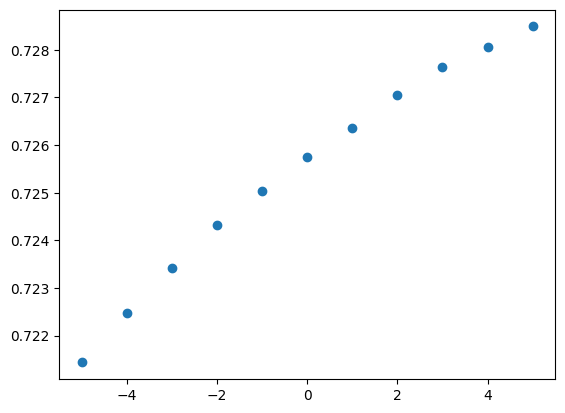

In [27]:

x,y, inds = get_batch(1, 100, 1,device)
# print(inds)
print(inds[0])
# print(model(x))
# print(y)
error_present(nn.Sigmoid()(model(x))[0], inds[0], y[0])
print(y)
print(nn.Sigmoid()(model(x)))

In [292]:
myRNN= nn.RNN(10,100,5).to(device)
print(myRNN(x))

(tensor([[[-0.0241, -0.0050, -0.0436,  ...,  0.0630, -0.1782,  0.0905],
         [-0.0416, -0.0136, -0.0568,  ...,  0.0361, -0.1718,  0.0904],
         [-0.0542, -0.0191, -0.0371,  ...,  0.0546, -0.1764,  0.0810],
         ...,
         [-0.0719, -0.0675, -0.0368,  ...,  0.0970, -0.2168,  0.0861],
         [-0.0404, -0.0170, -0.0637,  ...,  0.0535, -0.1707,  0.0789],
         [-0.0438, -0.0119, -0.0418,  ...,  0.0529, -0.1878,  0.0725]]],
       device='cuda:0', grad_fn=<CudnnRnnBackward0>), tensor([[[ 0.3606,  0.3763, -0.0703,  ...,  0.4405, -0.0639, -0.0504],
         [-0.1602,  0.0735,  0.1989,  ..., -0.1785, -0.3362,  0.3406],
         [ 0.3833,  0.1238,  0.0771,  ..., -0.2267,  0.0039,  0.1872],
         ...,
         [ 0.0477, -0.1614,  0.4257,  ..., -0.1218, -0.0999, -0.2118],
         [ 0.2183,  0.1890,  0.2391,  ..., -0.0024, -0.1767,  0.2191],
         [ 0.3539,  0.1075, -0.1330,  ...,  0.2023,  0.1865,  0.1567]],

        [[ 0.1841, -0.1916,  0.1030,  ..., -0.1199, -0.0565, 